In [79]:
import numpy as np
import pandas as pd 
import datetime

import seaborn as sns
import matplotlib.pyplot as plt

import sys
import warnings
warnings.filterwarnings("ignore")
from mlxtend.preprocessing import TransactionEncoder
from apyori import apriori 
from mlxtend.frequent_patterns import association_rules
import math

In [2]:
#!pip install mlxtend

In [3]:
#!pip install apyori

In [4]:
# conda install -c conda-forge fastparquet

### Data Prep

In [5]:
articles = pd.read_parquet('articles_20ss_cleaned.parquet', engine='fastparquet')
customers = pd.read_parquet('customers_20ss_cleaned.parquet', engine='fastparquet')
transactions = pd.read_parquet('transactions_20ss_cleaned.parquet', engine='fastparquet')

In [7]:
transactions

,t_dat,customer_id,article_id,price,sales_channel_id,month,day
0,2020-03-01,-7200416642310594310,751628002,0.022017,1,3,1
1,2020-03-01,8486166240428812738,675662028,0.035576,2,3,1
2,2020-03-01,-761612008142234995,821152004,0.025407,2,3,1
3,2020-03-01,-761612008142234995,860738001,0.025407,2,3,1
4,2020-03-01,-1779128939320411371,822957002,0.045746,2,3,1
...,...,...,...,...,...,...,...
6812501,2020-08-31,-8616969130790625436,658030020,0.050831,1,8,31
6812502,2020-08-31,-3663255835033856802,923643001,0.025407,2,8,31
6812503,2020-08-31,-3663255835033856802,894320001,0.033881,2,8,31
6812504,2020-08-31,9003752421700034502,873678002,0.025407,1,8,31


In [8]:
articles

,article_id,product_group_name,graphical_appearance_name,perceived_colour_master_name,index_group_name,garment_group_name
0,108775015,Garment Upper body,Solid,Black,Ladieswear,Jersey Basic
1,108775044,Garment Upper body,Solid,White,Ladieswear,Jersey Basic
2,110065001,Underwear,Solid,Black,Ladieswear,"Under-, Nightwear"
3,110065002,Underwear,Solid,White,Ladieswear,"Under-, Nightwear"
4,110065011,Underwear,Solid,Beige,Ladieswear,"Under-, Nightwear"
...,...,...,...,...,...,...
50594,947060001,Nightwear,All over pattern,Blue,Menswear,"Under-, Nightwear"
50595,947509001,Accessories,Solid,Brown,Ladieswear,Accessories
50596,949551001,Garment Upper body,Solid,Black,Divided,Knitwear
50597,949551002,Garment Upper body,Solid,Pink,Divided,Knitwear


In [9]:
customers

,customer_id,club_member_status,age,postal_code,gender
0,6883939031699146327,ACTIVE,49.0,-519588189372251904,Female
1,-7200416642310594310,ACTIVE,25.0,-4021669266154835881,Female
2,-6846340800584936,ACTIVE,24.0,652878820000628956,Male
3,-283965518499174310,ACTIVE,52.0,7238475373795629853,Male
4,-8334631767138808638,ACTIVE,32.0,7015195924696657018,Female
...,...,...,...,...,...
727467,5823894334162843119,ACTIVE,52.0,-1879465132567127460,Female
727468,7551062398649767985,ACTIVE,24.0,-4394679890517362458,Female
727469,-9141402131989464905,ACTIVE,21.0,6093971039741956030,Male
727470,-8286316756823862684,ACTIVE,21.0,-5473632269620177389,Male


In [6]:
# Merge Transactions and Articles dfs by article_id
trans_info = pd.merge(transactions,articles, on = 'article_id' )
trans_info

,t_dat,customer_id,article_id,price,sales_channel_id,month,day,product_group_name,graphical_appearance_name,perceived_colour_master_name,index_group_name,garment_group_name
0,2020-03-01,-7200416642310594310,751628002,0.022017,1,3,1,Garment Full body,Solid,Blue,Ladieswear,Dresses Ladies
1,2020-03-07,1245616551741560361,751628002,0.017610,1,3,7,Garment Full body,Solid,Blue,Ladieswear,Dresses Ladies
2,2020-03-13,1081040343499318993,751628002,0.022017,1,3,13,Garment Full body,Solid,Blue,Ladieswear,Dresses Ladies
3,2020-05-07,5636402184158975187,751628002,0.022017,1,5,7,Garment Full body,Solid,Blue,Ladieswear,Dresses Ladies
4,2020-05-07,8626027306265748694,751628002,0.022017,1,5,7,Garment Full body,Solid,Blue,Ladieswear,Dresses Ladies
...,...,...,...,...,...,...,...,...,...,...,...,...
6812501,2020-08-31,5183570730531146925,880159001,0.042356,2,8,31,Garment Upper body,Colour blocking,Pink,Sport,Dressed
6812502,2020-08-31,-1312129328298988413,594541041,0.016424,2,8,31,Garment Lower body,Solid,Green,Baby/Children,Jersey Basic
6812503,2020-08-31,-8685997179095487903,946764003,0.101678,2,8,31,Garment Upper body,Solid,Beige,Ladieswear,Dressed
6812504,2020-08-31,5024850930158354936,701134029,0.003373,1,8,31,Socks & Tights,Jacquard,Grey,Menswear,Socks and Tights


In [7]:
trans_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6812506 entries, 0 to 6812505
Data columns (total 12 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   t_dat                         datetime64[ns]
 1   customer_id                   int64         
 2   article_id                    int64         
 3   price                         float32       
 4   sales_channel_id              int8          
 5   month                         int8          
 6   day                           int8          
 7   product_group_name            object        
 8   graphical_appearance_name     object        
 9   perceived_colour_master_name  object        
 10  index_group_name              object        
 11  garment_group_name            object        
dtypes: datetime64[ns](1), float32(1), int64(2), int8(3), object(5)
memory usage: 513.3+ MB


In [8]:
# Convert to str
trans_info['customer_id'] = trans_info['customer_id'].astype(str)
trans_info['article_id'] = trans_info['article_id'].astype(str)

In [9]:
trans_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6812506 entries, 0 to 6812505
Data columns (total 12 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   t_dat                         datetime64[ns]
 1   customer_id                   object        
 2   article_id                    object        
 3   price                         float32       
 4   sales_channel_id              int8          
 5   month                         int8          
 6   day                           int8          
 7   product_group_name            object        
 8   graphical_appearance_name     object        
 9   perceived_colour_master_name  object        
 10  index_group_name              object        
 11  garment_group_name            object        
dtypes: datetime64[ns](1), float32(1), int8(3), object(7)
memory usage: 513.3+ MB


In [10]:
# Grouped df by customer_id: Derive df with ine customer_id and list of purchases for each row
grouped_df= trans_info[['customer_id','article_id']].groupby('customer_id').agg({'article_id':lambda x:list(x)})
grouped_df

,article_id
customer_id,
-1000006309069194455,[817472002]
-1000036844604231611,"[805000001, 804992024, 730683050]"
-1000050196267142131,"[685816001, 685816004, 886189001, 685816053, 6..."
-1000052543077660214,[841260011]
-1000060282539483427,"[740519002, 751471001, 817152001, 753737001, 7..."
...,...
999902799079936447,"[505882002, 854043006, 556539001, 699081001, 8..."
999919239910340283,"[723469001, 864040001, 764488006, 697920045, 8..."
999938001182428423,"[590928001, 451744018, 834217004, 877599002]"


In [15]:
# Test the limit for size
sampled = grouped_df['article_id'].sample(frac=0.1, random_state=1)
sampled

customer_id
5953062630673999231     [783707047, 882888002, 841260001, 577425021, 3...
8630614962915846660     [791587009, 579541001, 821336001, 808748003, 8...
-7662097304203325720    [740922001, 717773033, 755309005, 563660002, 6...
4652844785547307826          [831269002, 714803008, 811871001, 874546001]
7494580525831625647     [736531001, 736530017, 797527001, 810825002, 7...
                                              ...                        
-8951822875407578707                    [879949002, 854776001, 766917002]
-1100140737052248608    [800691008, 800691008, 800691007, 800691007, 8...
-2163274666182815327    [852174001, 914537001, 900235003, 902023001, 9...
-3004466747478532864                    [770315009, 861847006, 832453003]
-5264379247554107460                               [682289012, 724905016]
Name: article_id, Length: 72747, dtype: object

### Sampling

In [11]:
sampled1 = grouped_df['article_id'].sample(n=5000, random_state=42)
sampled2 = grouped_df['article_id'].sample(n=5000, random_state=1)
sampled3 = grouped_df['article_id'].sample(n=5000, random_state=18)
sampled4 = grouped_df['article_id'].sample(n=5000, random_state=105)
sampled5 = grouped_df['article_id'].sample(n=5000, random_state=99)

In [12]:
sampled1

customer_id
3992930880288688918     [749699019, 687704022, 759814020, 706016015, 5...
8969756082449117856     [811777007, 832482004, 883720001, 817477005, 8...
1457713184395293986     [739590032, 860949002, 811925005, 811927004, 8...
-5904832937385726333    [750330003, 785575002, 825550001, 771235003, 8...
8258449696411839068     [776163005, 652924010, 652924004, 785041005, 6...
                                              ...                        
2359524882897844258          [866837002, 857794006, 763011001, 888035002]
-6070975638282490405    [817361002, 817361002, 817361002, 817361002, 8...
7838809756661236677                                           [750422018]
8041379291672436682     [802485004, 802485004, 849859003, 684209019, 7...
7333404729792400028     [778064003, 778064003, 778064003, 759871001, 7...
Name: article_id, Length: 5000, dtype: object

In [13]:
sampled6 = grouped_df['article_id'].sample(n=5000, random_state=10)
sampled7 = grouped_df['article_id'].sample(n=5000, random_state=55)
sampled8 = grouped_df['article_id'].sample(n=5000, random_state=111)
sampled9 = grouped_df['article_id'].sample(n=5000, random_state=123)
sampled10 = grouped_df['article_id'].sample(n=5000, random_state=98)

In [14]:
# Helper Function for Transcation Encoding & Dataframe building
def to_df(sampled):
    ls = sampled.reset_index()['article_id'].tolist()
    te = TransactionEncoder()
    te_ary = te.fit(ls).transform(ls)
    int_type = te_ary.astype("int")
    df=pd.DataFrame(int_type, columns=te.columns_)
    return df

In [15]:
df1 = to_df(sampled1)
df2 = to_df(sampled2)
df3 = to_df(sampled3)
df4 = to_df(sampled4)
df5 = to_df(sampled5)

In [16]:
df6 = to_df(sampled6)
df7 = to_df(sampled7)
df8 = to_df(sampled8)
df9 = to_df(sampled9)
df10 = to_df(sampled10)

### Apyori Alogrithm Application

In [17]:
from mlxtend.frequent_patterns import apriori
# Define helper funcation that return itemsets with support >= 0.002 
def get_itemsets(df):
    frequent_itemsets = apriori(df, min_support=0.002, use_colnames=True)
    frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
    return frequent_itemsets

In [18]:
frequent_itemsets1 = get_itemsets(df1)

In [19]:
frequent_itemsets1

,support,itemsets,length
0,0.0024,(153115020),1
1,0.0038,(160442007),1
2,0.0024,(160442010),1
3,0.0024,(179950001),1
4,0.0028,(212629004),1
...,...,...,...
874,0.0020,"(841699003, 834217009)",2
875,0.0020,"(841383003, 841383002)",2
876,0.0024,"(843873007, 843872006)",2
877,0.0024,"(854619003, 850176003)",2


In [21]:
frequent_itemsets2 = get_itemsets(df2)
frequent_itemsets3 = get_itemsets(df3)
frequent_itemsets4 = get_itemsets(df4)
frequent_itemsets5 = get_itemsets(df5)

In [22]:
frequent_itemsets6 = get_itemsets(df6)
frequent_itemsets7 = get_itemsets(df7)
frequent_itemsets8 = get_itemsets(df8)
frequent_itemsets9 = get_itemsets(df9)
frequent_itemsets10 = get_itemsets(df10)

In [23]:
# Helper funcation to access association rules
def get_association_rules(frequent_itemsets):
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
    return rules

In [24]:
rules1 = get_association_rules(frequent_itemsets1)
rules1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(559616020),(739590024),0.0046,0.0044,0.0042,0.913043,207.509881,0.004180,11.449400
1,(739590024),(559616020),0.0044,0.0046,0.0042,0.954545,207.509881,0.004180,21.898800
2,(559630026),(599580055),0.0038,0.0076,0.0024,0.631579,83.102493,0.002371,2.693657
3,(599580055),(559630026),0.0076,0.0038,0.0024,0.315789,83.102493,0.002371,1.455985
4,(776237011),(599580038),0.0062,0.0082,0.0036,0.580645,70.810386,0.003549,2.365062
5,(599580038),(776237011),0.0082,0.0062,0.0036,0.439024,70.810386,0.003549,1.771557
6,(806225008),(599580038),0.0036,0.0082,0.0020,0.555556,67.750678,0.001970,2.231550
7,(599580038),(806225008),0.0082,0.0036,0.0020,0.243902,67.750678,0.001970,1.317819
8,(776237021),(599580047),0.0030,0.0038,0.0026,0.866667,228.070175,0.002589,7.471500
9,(599580047),(776237021),0.0038,0.0030,0.0026,0.684211,228.070175,0.002589,3.157167


In [26]:
rules2 = get_association_rules(frequent_itemsets2)
rules3 = get_association_rules(frequent_itemsets3)
rules4 = get_association_rules(frequent_itemsets4)
rules5 = get_association_rules(frequent_itemsets5)

In [27]:
rules6 = get_association_rules(frequent_itemsets6)
rules7 = get_association_rules(frequent_itemsets7)
rules8 = get_association_rules(frequent_itemsets8)
rules9 = get_association_rules(frequent_itemsets9)
rules10= get_association_rules(frequent_itemsets10)

In [28]:
# Combine rules from 10 Samples together
rules = pd.concat([rules1,rules2,rules3,rules4,rules5,rules6,rules7,rules8,rules9,rules10], axis=0)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(559616020),(739590024),0.0046,0.0044,0.0042,0.913043,207.509881,0.004180,11.449400
1,(739590024),(559616020),0.0044,0.0046,0.0042,0.954545,207.509881,0.004180,21.898800
2,(559630026),(599580055),0.0038,0.0076,0.0024,0.631579,83.102493,0.002371,2.693657
3,(599580055),(559630026),0.0076,0.0038,0.0024,0.315789,83.102493,0.002371,1.455985
4,(776237011),(599580038),0.0062,0.0082,0.0036,0.580645,70.810386,0.003549,2.365062
...,...,...,...,...,...,...,...,...,...
27,(860949001),(739590031),0.0030,0.0024,0.0020,0.666667,277.777778,0.001993,2.992800
28,(823165001),(823118001),0.0048,0.0032,0.0028,0.583333,182.291667,0.002785,2.392320
29,(823118001),(823165001),0.0032,0.0048,0.0028,0.875000,182.291667,0.002785,7.961600
30,(841383003),(841383002),0.0062,0.0072,0.0024,0.387097,53.763441,0.002355,1.619832


In [29]:
# Drop duplicates rules
rules.drop_duplicates()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(559616020),(739590024),0.0046,0.0044,0.0042,0.913043,207.509881,0.004180,11.449400
1,(739590024),(559616020),0.0044,0.0046,0.0042,0.954545,207.509881,0.004180,21.898800
2,(559630026),(599580055),0.0038,0.0076,0.0024,0.631579,83.102493,0.002371,2.693657
3,(599580055),(559630026),0.0076,0.0038,0.0024,0.315789,83.102493,0.002371,1.455985
4,(776237011),(599580038),0.0062,0.0082,0.0036,0.580645,70.810386,0.003549,2.365062
...,...,...,...,...,...,...,...,...,...
27,(860949001),(739590031),0.0030,0.0024,0.0020,0.666667,277.777778,0.001993,2.992800
28,(823165001),(823118001),0.0048,0.0032,0.0028,0.583333,182.291667,0.002785,2.392320
29,(823118001),(823165001),0.0032,0.0048,0.0028,0.875000,182.291667,0.002785,7.961600
30,(841383003),(841383002),0.0062,0.0072,0.0024,0.387097,53.763441,0.002355,1.619832


### Brief visualization on Results

#### Top 6 Lift Purchases

In [85]:
rules.sort_values(by = 'lift', ascending = False).head(6)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_info,consequents_info
2,(559616017),(739590022),0.0022,0.0022,0.0020,0.909091,413.223140,0.001995,10.9758,"[[559616017, Swimwear, Solid, Orange, Ladieswe...","[[739590022, Swimwear, Solid, Orange, Ladieswe..."
3,(739590022),(559616017),0.0022,0.0022,0.0020,0.909091,413.223140,0.001995,10.9758,"[[739590022, Swimwear, Solid, Orange, Ladieswe...","[[559616017, Swimwear, Solid, Orange, Ladieswe..."
14,(832320002),(832321002),0.0024,0.0022,0.0020,0.833333,378.787879,0.001995,5.9868,"[[832320002, Swimwear, Solid, Green, Ladieswea...","[[832321002, Swimwear, All over pattern, Green..."
15,(832321002),(832320002),0.0022,0.0024,0.0020,0.909091,378.787879,0.001995,10.9736,"[[832321002, Swimwear, All over pattern, Green...","[[832320002, Swimwear, Solid, Green, Ladieswea..."
0,(559616020),(739590024),0.0026,0.0024,0.0022,0.846154,352.564103,0.002194,6.4844,"[[559616020, Swimwear, Solid, Green, Ladieswea...","[[739590024, Swimwear, Solid, Green, Ladieswea..."
1,(739590024),(559616020),0.0024,0.0026,0.0022,0.916667,352.564103,0.002194,11.9688,"[[739590024, Swimwear, Solid, Green, Ladieswea...","[[559616020, Swimwear, Solid, Green, Ladieswea..."


#### Antecedents & Consequents Info

In [36]:
antecedents = rules['antecedents'].apply(lambda x:list(x))
consequents = rules['consequents'].apply(lambda x:list(x))
ante_info = []
for i in antecedents:
    a = articles[articles['article_id'] == int(i[0])]
    ante_info.append(a.values.tolist())
rules['antecedents_info'] = ante_info   
conseq_info = []
for i in consequents:
    a = articles[articles['article_id'] == int(i[0])]
    conseq_info.append(a.values.tolist())
rules['consequents_info'] = conseq_info
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_info,consequents_info
0,(559616020),(739590024),0.0046,0.0044,0.0042,0.913043,207.509881,0.004180,11.449400,"[[559616020, Swimwear, Solid, Green, Ladieswea...","[[739590024, Swimwear, Solid, Green, Ladieswea..."
1,(739590024),(559616020),0.0044,0.0046,0.0042,0.954545,207.509881,0.004180,21.898800,"[[739590024, Swimwear, Solid, Green, Ladieswea...","[[559616020, Swimwear, Solid, Green, Ladieswea..."
2,(559630026),(599580055),0.0038,0.0076,0.0024,0.631579,83.102493,0.002371,2.693657,"[[559630026, Swimwear, All over pattern, Green...","[[599580055, Swimwear, Dot, Green, Ladieswear,..."
3,(599580055),(559630026),0.0076,0.0038,0.0024,0.315789,83.102493,0.002371,1.455985,"[[599580055, Swimwear, Dot, Green, Ladieswear,...","[[559630026, Swimwear, All over pattern, Green..."
4,(776237011),(599580038),0.0062,0.0082,0.0036,0.580645,70.810386,0.003549,2.365062,"[[776237011, Swimwear, Solid, Red, Ladieswear,...","[[599580038, Swimwear, Solid, Red, Ladieswear,..."
...,...,...,...,...,...,...,...,...,...,...,...
27,(860949001),(739590031),0.0030,0.0024,0.0020,0.666667,277.777778,0.001993,2.992800,"[[860949001, Swimwear, Stripe, Green, Ladieswe...","[[739590031, Swimwear, Stripe, Green, Ladieswe..."
28,(823165001),(823118001),0.0048,0.0032,0.0028,0.583333,182.291667,0.002785,2.392320,"[[823165001, Swimwear, Solid, Blue, Ladieswear...","[[823118001, Swimwear, Solid, Blue, Ladieswear..."
29,(823118001),(823165001),0.0032,0.0048,0.0028,0.875000,182.291667,0.002785,7.961600,"[[823118001, Swimwear, Solid, Blue, Ladieswear...","[[823165001, Swimwear, Solid, Blue, Ladieswear..."
30,(841383003),(841383002),0.0062,0.0072,0.0024,0.387097,53.763441,0.002355,1.619832,"[[841383003, Garment Upper body, Solid, White,...","[[841383002, Garment Upper body, Solid, Black,..."


In [50]:
rules.sort_values(by = 'lift', ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_info,consequents_info
2,(739590022),(559616017),0.0022,0.0022,0.0020,0.909091,413.223140,0.001995,10.975800,"[[739590022, Swimwear, Solid, Orange, Ladieswe...","[[559616017, Swimwear, Solid, Orange, Ladieswe..."
3,(559616017),(739590022),0.0022,0.0022,0.0020,0.909091,413.223140,0.001995,10.975800,"[[559616017, Swimwear, Solid, Orange, Ladieswe...","[[739590022, Swimwear, Solid, Orange, Ladieswe..."
14,(832321002),(832320002),0.0022,0.0024,0.0020,0.909091,378.787879,0.001995,10.973600,"[[832321002, Swimwear, All over pattern, Green...","[[832320002, Swimwear, Solid, Green, Ladieswea..."
15,(832320002),(832321002),0.0024,0.0022,0.0020,0.833333,378.787879,0.001995,5.986800,"[[832320002, Swimwear, Solid, Green, Ladieswea...","[[832321002, Swimwear, All over pattern, Green..."
0,(559616020),(739590024),0.0026,0.0024,0.0022,0.846154,352.564103,0.002194,6.484400,"[[559616020, Swimwear, Solid, Green, Ladieswea...","[[739590024, Swimwear, Solid, Green, Ladieswea..."
...,...,...,...,...,...,...,...,...,...,...,...
1,(372860001),(372860002),0.0116,0.0092,0.0022,0.189655,20.614693,0.002093,1.222689,"[[372860001, Socks & Tights, Solid, Black, Lad...","[[372860002, Socks & Tights, Solid, White, Lad..."
8,(610776001),(610776002),0.0094,0.0110,0.0020,0.212766,19.342360,0.001897,1.256297,"[[610776001, Garment Upper body, Solid, White,...","[[610776002, Garment Upper body, Solid, Black,..."
9,(610776002),(610776001),0.0110,0.0094,0.0020,0.181818,19.342360,0.001897,1.210733,"[[610776002, Garment Upper body, Solid, Black,...","[[610776001, Garment Upper body, Solid, White,..."
8,(610776001),(610776002),0.0106,0.0134,0.0026,0.245283,18.304703,0.002458,1.307245,"[[610776001, Garment Upper body, Solid, White,...","[[610776002, Garment Upper body, Solid, Black,..."


#### Product Group Name

In [59]:
ante_product_group = []
for i in antecedents:
    a = articles[articles['article_id'] == int(i[0])]['product_group_name'].values
    ante_product_group.append(a)
rules['antecedents_product_group'] = ante_product_group
consq_product_group = []
for i in antecedents:
    a = articles[articles['article_id'] == int(i[0])]['product_group_name'].values
    consq_product_group.append(a)
rules['consequents_product_group'] = consq_product_group
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_info,consequents_info,antecedents_product_group,consequents_product_group
0,(559616020),(739590024),0.0046,0.0044,0.0042,0.913043,207.509881,0.004180,11.449400,"[[559616020, Swimwear, Solid, Green, Ladieswea...","[[739590024, Swimwear, Solid, Green, Ladieswea...",[Swimwear],[Swimwear]
1,(739590024),(559616020),0.0044,0.0046,0.0042,0.954545,207.509881,0.004180,21.898800,"[[739590024, Swimwear, Solid, Green, Ladieswea...","[[559616020, Swimwear, Solid, Green, Ladieswea...",[Swimwear],[Swimwear]
2,(599580055),(559630026),0.0076,0.0038,0.0024,0.315789,83.102493,0.002371,1.455985,"[[599580055, Swimwear, Dot, Green, Ladieswear,...","[[559630026, Swimwear, All over pattern, Green...",[Swimwear],[Swimwear]
3,(559630026),(599580055),0.0038,0.0076,0.0024,0.631579,83.102493,0.002371,2.693657,"[[559630026, Swimwear, All over pattern, Green...","[[599580055, Swimwear, Dot, Green, Ladieswear,...",[Swimwear],[Swimwear]
4,(776237011),(599580038),0.0062,0.0082,0.0036,0.580645,70.810386,0.003549,2.365062,"[[776237011, Swimwear, Solid, Red, Ladieswear,...","[[599580038, Swimwear, Solid, Red, Ladieswear,...",[Swimwear],[Swimwear]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,(860949001),(739590031),0.0030,0.0024,0.0020,0.666667,277.777778,0.001993,2.992800,"[[860949001, Swimwear, Stripe, Green, Ladieswe...","[[739590031, Swimwear, Stripe, Green, Ladieswe...",[Swimwear],[Swimwear]
28,(823118001),(823165001),0.0032,0.0048,0.0028,0.875000,182.291667,0.002785,7.961600,"[[823118001, Swimwear, Solid, Blue, Ladieswear...","[[823165001, Swimwear, Solid, Blue, Ladieswear...",[Swimwear],[Swimwear]
29,(823165001),(823118001),0.0048,0.0032,0.0028,0.583333,182.291667,0.002785,2.392320,"[[823165001, Swimwear, Solid, Blue, Ladieswear...","[[823118001, Swimwear, Solid, Blue, Ladieswear...",[Swimwear],[Swimwear]
30,(841383002),(841383003),0.0072,0.0062,0.0024,0.333333,53.763441,0.002355,1.490700,"[[841383002, Garment Upper body, Solid, Black,...","[[841383003, Garment Upper body, Solid, White,...",[Garment Upper body],[Garment Upper body]


In [83]:
# Product with high probability of purchase together fell into the same product group
rules[rules['antecedents_product_group'] == rules['consequents_product_group']]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_info,consequents_info,antecedents_product_group,consequents_product_group
0,(559616020),(739590024),0.0046,0.0044,0.0042,0.913043,207.509881,0.004180,11.449400,"[[559616020, Swimwear, Solid, Green, Ladieswea...","[[739590024, Swimwear, Solid, Green, Ladieswea...",[Swimwear],[Swimwear]
1,(739590024),(559616020),0.0044,0.0046,0.0042,0.954545,207.509881,0.004180,21.898800,"[[739590024, Swimwear, Solid, Green, Ladieswea...","[[559616020, Swimwear, Solid, Green, Ladieswea...",[Swimwear],[Swimwear]
2,(599580055),(559630026),0.0076,0.0038,0.0024,0.315789,83.102493,0.002371,1.455985,"[[599580055, Swimwear, Dot, Green, Ladieswear,...","[[559630026, Swimwear, All over pattern, Green...",[Swimwear],[Swimwear]
3,(559630026),(599580055),0.0038,0.0076,0.0024,0.631579,83.102493,0.002371,2.693657,"[[559630026, Swimwear, All over pattern, Green...","[[599580055, Swimwear, Dot, Green, Ladieswear,...",[Swimwear],[Swimwear]
4,(776237011),(599580038),0.0062,0.0082,0.0036,0.580645,70.810386,0.003549,2.365062,"[[776237011, Swimwear, Solid, Red, Ladieswear,...","[[599580038, Swimwear, Solid, Red, Ladieswear,...",[Swimwear],[Swimwear]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,(860949001),(739590031),0.0030,0.0024,0.0020,0.666667,277.777778,0.001993,2.992800,"[[860949001, Swimwear, Stripe, Green, Ladieswe...","[[739590031, Swimwear, Stripe, Green, Ladieswe...",[Swimwear],[Swimwear]
28,(823118001),(823165001),0.0032,0.0048,0.0028,0.875000,182.291667,0.002785,7.961600,"[[823118001, Swimwear, Solid, Blue, Ladieswear...","[[823165001, Swimwear, Solid, Blue, Ladieswear...",[Swimwear],[Swimwear]
29,(823165001),(823118001),0.0048,0.0032,0.0028,0.583333,182.291667,0.002785,2.392320,"[[823165001, Swimwear, Solid, Blue, Ladieswear...","[[823118001, Swimwear, Solid, Blue, Ladieswear...",[Swimwear],[Swimwear]
30,(841383002),(841383003),0.0072,0.0062,0.0024,0.333333,53.763441,0.002355,1.490700,"[[841383002, Garment Upper body, Solid, Black,...","[[841383003, Garment Upper body, Solid, White,...",[Garment Upper body],[Garment Upper body]


<AxesSubplot:title={'center':'Often Purchase Together by Product Group Name'}, ylabel='antecedents_product_group'>

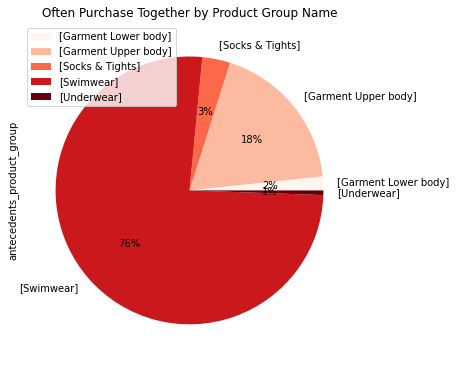

In [100]:
rules['antecedents_product_group'].value_counts().sort_index().plot.pie(title = "Often Purchase Together by Product Group Name",
                                                                      legend = True, autopct='%1.0f%%', fontsize=10, colormap = 'Reds',
                                                                      figsize=(6,10))


In [107]:
def get_article_feature(col,ante_col_name, cosq_col_name):
    temp_ls1 = []
    temp_ls2 = []
    for i in antecedents:
        a = articles[articles['article_id'] == int(i[0])][col].values
        temp_ls1.append(a)
    rules[ante_col_name] = temp_ls1
    for j in consequents:
        b = articles[articles['article_id'] == int(j[0])][col].values
        temp_ls2.append(b)
    rules[cosq_col_name] = temp_ls2
    return rules

#### Garment Group

In [108]:
get_article_feature('garment_group_name','ante_garment_group','consq_garment_group')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_info,consequents_info,antecedents_product_group,consequents_product_group,ante_garment_group,consq_garment_group
0,(559616020),(739590024),0.0046,0.0044,0.0042,0.913043,207.509881,0.004180,11.449400,"[[559616020, Swimwear, Solid, Green, Ladieswea...","[[739590024, Swimwear, Solid, Green, Ladieswea...",[Swimwear],[Swimwear],[Swimwear],[Swimwear]
1,(739590024),(559616020),0.0044,0.0046,0.0042,0.954545,207.509881,0.004180,21.898800,"[[739590024, Swimwear, Solid, Green, Ladieswea...","[[559616020, Swimwear, Solid, Green, Ladieswea...",[Swimwear],[Swimwear],[Swimwear],[Swimwear]
2,(599580055),(559630026),0.0076,0.0038,0.0024,0.315789,83.102493,0.002371,1.455985,"[[599580055, Swimwear, Dot, Green, Ladieswear,...","[[559630026, Swimwear, All over pattern, Green...",[Swimwear],[Swimwear],[Swimwear],[Swimwear]
3,(559630026),(599580055),0.0038,0.0076,0.0024,0.631579,83.102493,0.002371,2.693657,"[[559630026, Swimwear, All over pattern, Green...","[[599580055, Swimwear, Dot, Green, Ladieswear,...",[Swimwear],[Swimwear],[Swimwear],[Swimwear]
4,(776237011),(599580038),0.0062,0.0082,0.0036,0.580645,70.810386,0.003549,2.365062,"[[776237011, Swimwear, Solid, Red, Ladieswear,...","[[599580038, Swimwear, Solid, Red, Ladieswear,...",[Swimwear],[Swimwear],[Swimwear],[Swimwear]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,(860949001),(739590031),0.0030,0.0024,0.0020,0.666667,277.777778,0.001993,2.992800,"[[860949001, Swimwear, Stripe, Green, Ladieswe...","[[739590031, Swimwear, Stripe, Green, Ladieswe...",[Swimwear],[Swimwear],[Swimwear],[Swimwear]
28,(823118001),(823165001),0.0032,0.0048,0.0028,0.875000,182.291667,0.002785,7.961600,"[[823118001, Swimwear, Solid, Blue, Ladieswear...","[[823165001, Swimwear, Solid, Blue, Ladieswear...",[Swimwear],[Swimwear],[Swimwear],[Swimwear]
29,(823165001),(823118001),0.0048,0.0032,0.0028,0.583333,182.291667,0.002785,2.392320,"[[823165001, Swimwear, Solid, Blue, Ladieswear...","[[823118001, Swimwear, Solid, Blue, Ladieswear...",[Swimwear],[Swimwear],[Swimwear],[Swimwear]
30,(841383002),(841383003),0.0072,0.0062,0.0024,0.333333,53.763441,0.002355,1.490700,"[[841383002, Garment Upper body, Solid, Black,...","[[841383003, Garment Upper body, Solid, White,...",[Garment Upper body],[Garment Upper body],[Jersey Basic],[Jersey Basic]


<AxesSubplot:title={'center':'Often Purchase Together by Product Group Name'}, ylabel='ante_garment_group'>

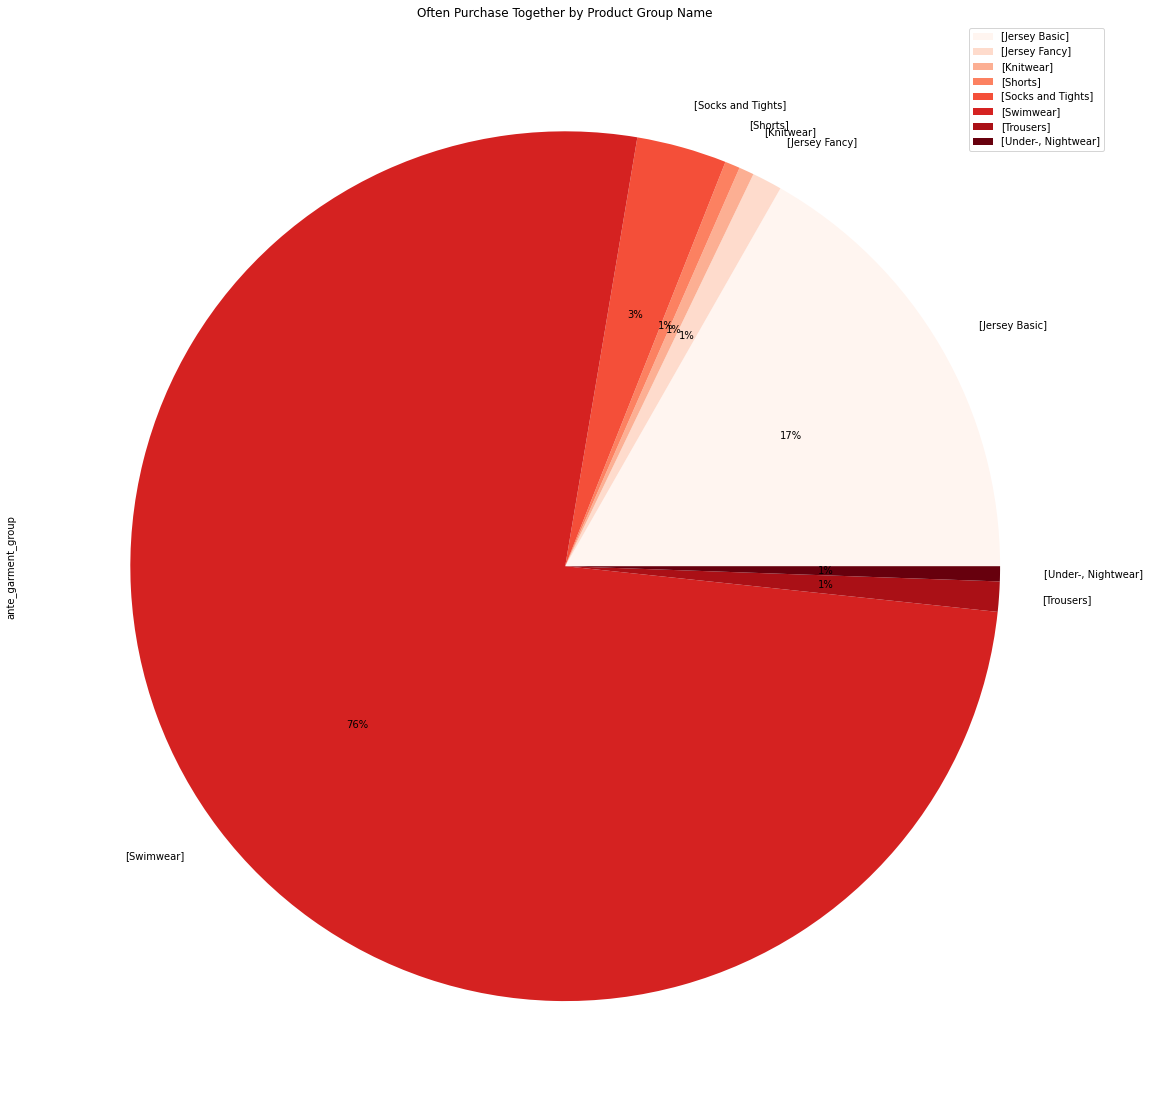

In [112]:
rules['ante_garment_group'].value_counts().sort_index().plot.pie(title = "Often Purchase Together by Product Group Name",
                                                                      legend = True, autopct='%1.0f%%', fontsize=10, colormap = 'Reds',
                                                                      figsize=(20,20))



#### Graphical Appearance

In [113]:
get_article_feature('graphical_appearance_name','ante_graphical','consq_graphical')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_info,consequents_info,antecedents_product_group,consequents_product_group,ante_garment_group,consq_garment_group,ante_graphical,consq_graphical
0,(559616020),(739590024),0.0046,0.0044,0.0042,0.913043,207.509881,0.004180,11.449400,"[[559616020, Swimwear, Solid, Green, Ladieswea...","[[739590024, Swimwear, Solid, Green, Ladieswea...",[Swimwear],[Swimwear],[Swimwear],[Swimwear],[Solid],[Solid]
1,(739590024),(559616020),0.0044,0.0046,0.0042,0.954545,207.509881,0.004180,21.898800,"[[739590024, Swimwear, Solid, Green, Ladieswea...","[[559616020, Swimwear, Solid, Green, Ladieswea...",[Swimwear],[Swimwear],[Swimwear],[Swimwear],[Solid],[Solid]
2,(599580055),(559630026),0.0076,0.0038,0.0024,0.315789,83.102493,0.002371,1.455985,"[[599580055, Swimwear, Dot, Green, Ladieswear,...","[[559630026, Swimwear, All over pattern, Green...",[Swimwear],[Swimwear],[Swimwear],[Swimwear],[Dot],[All over pattern]
3,(559630026),(599580055),0.0038,0.0076,0.0024,0.631579,83.102493,0.002371,2.693657,"[[559630026, Swimwear, All over pattern, Green...","[[599580055, Swimwear, Dot, Green, Ladieswear,...",[Swimwear],[Swimwear],[Swimwear],[Swimwear],[All over pattern],[Dot]
4,(776237011),(599580038),0.0062,0.0082,0.0036,0.580645,70.810386,0.003549,2.365062,"[[776237011, Swimwear, Solid, Red, Ladieswear,...","[[599580038, Swimwear, Solid, Red, Ladieswear,...",[Swimwear],[Swimwear],[Swimwear],[Swimwear],[Solid],[Solid]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,(860949001),(739590031),0.0030,0.0024,0.0020,0.666667,277.777778,0.001993,2.992800,"[[860949001, Swimwear, Stripe, Green, Ladieswe...","[[739590031, Swimwear, Stripe, Green, Ladieswe...",[Swimwear],[Swimwear],[Swimwear],[Swimwear],[Stripe],[Stripe]
28,(823118001),(823165001),0.0032,0.0048,0.0028,0.875000,182.291667,0.002785,7.961600,"[[823118001, Swimwear, Solid, Blue, Ladieswear...","[[823165001, Swimwear, Solid, Blue, Ladieswear...",[Swimwear],[Swimwear],[Swimwear],[Swimwear],[Solid],[Solid]
29,(823165001),(823118001),0.0048,0.0032,0.0028,0.583333,182.291667,0.002785,2.392320,"[[823165001, Swimwear, Solid, Blue, Ladieswear...","[[823118001, Swimwear, Solid, Blue, Ladieswear...",[Swimwear],[Swimwear],[Swimwear],[Swimwear],[Solid],[Solid]
30,(841383002),(841383003),0.0072,0.0062,0.0024,0.333333,53.763441,0.002355,1.490700,"[[841383002, Garment Upper body, Solid, Black,...","[[841383003, Garment Upper body, Solid, White,...",[Garment Upper body],[Garment Upper body],[Jersey Basic],[Jersey Basic],[Solid],[Solid]


In [117]:
# Similar Graphical Appearance more likely to be bought together
# Solid-Solid, Dot-All over pattern, All over patter-Dot,Solid-Solid
rules[rules['ante_graphical'] == rules['consq_graphical']]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_info,consequents_info,antecedents_product_group,consequents_product_group,ante_garment_group,consq_garment_group,ante_graphical,consq_graphical
0,(559616020),(739590024),0.0046,0.0044,0.0042,0.913043,207.509881,0.004180,11.449400,"[[559616020, Swimwear, Solid, Green, Ladieswea...","[[739590024, Swimwear, Solid, Green, Ladieswea...",[Swimwear],[Swimwear],[Swimwear],[Swimwear],[Solid],[Solid]
1,(739590024),(559616020),0.0044,0.0046,0.0042,0.954545,207.509881,0.004180,21.898800,"[[739590024, Swimwear, Solid, Green, Ladieswea...","[[559616020, Swimwear, Solid, Green, Ladieswea...",[Swimwear],[Swimwear],[Swimwear],[Swimwear],[Solid],[Solid]
4,(776237011),(599580038),0.0062,0.0082,0.0036,0.580645,70.810386,0.003549,2.365062,"[[776237011, Swimwear, Solid, Red, Ladieswear,...","[[599580038, Swimwear, Solid, Red, Ladieswear,...",[Swimwear],[Swimwear],[Swimwear],[Swimwear],[Solid],[Solid]
5,(599580038),(776237011),0.0082,0.0062,0.0036,0.439024,70.810386,0.003549,1.771557,"[[599580038, Swimwear, Solid, Red, Ladieswear,...","[[776237011, Swimwear, Solid, Red, Ladieswear,...",[Swimwear],[Swimwear],[Swimwear],[Swimwear],[Solid],[Solid]
6,(599580038),(806225008),0.0082,0.0036,0.0020,0.243902,67.750678,0.001970,1.317819,"[[599580038, Swimwear, Solid, Red, Ladieswear,...","[[806225008, Swimwear, Solid, Red, Ladieswear,...",[Swimwear],[Swimwear],[Swimwear],[Swimwear],[Solid],[Solid]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,(860949001),(739590031),0.0030,0.0024,0.0020,0.666667,277.777778,0.001993,2.992800,"[[860949001, Swimwear, Stripe, Green, Ladieswe...","[[739590031, Swimwear, Stripe, Green, Ladieswe...",[Swimwear],[Swimwear],[Swimwear],[Swimwear],[Stripe],[Stripe]
28,(823118001),(823165001),0.0032,0.0048,0.0028,0.875000,182.291667,0.002785,7.961600,"[[823118001, Swimwear, Solid, Blue, Ladieswear...","[[823165001, Swimwear, Solid, Blue, Ladieswear...",[Swimwear],[Swimwear],[Swimwear],[Swimwear],[Solid],[Solid]
29,(823165001),(823118001),0.0048,0.0032,0.0028,0.583333,182.291667,0.002785,2.392320,"[[823165001, Swimwear, Solid, Blue, Ladieswear...","[[823118001, Swimwear, Solid, Blue, Ladieswear...",[Swimwear],[Swimwear],[Swimwear],[Swimwear],[Solid],[Solid]
30,(841383002),(841383003),0.0072,0.0062,0.0024,0.333333,53.763441,0.002355,1.490700,"[[841383002, Garment Upper body, Solid, Black,...","[[841383003, Garment Upper body, Solid, White,...",[Garment Upper body],[Garment Upper body],[Jersey Basic],[Jersey Basic],[Solid],[Solid]


In [125]:
rules['graphical'] = rules['ante_graphical'] + ' - '+rules['consq_graphical']

In [126]:
rules.graphical.value_counts()

TypeError: unhashable type: 'numpy.ndarray'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'numpy.ndarray'


[Solid - Solid]                          160
[Other structure - Other structure]       84
[All over pattern - All over pattern]     48
[Stripe - Stripe]                         28
[Dot - All over pattern]                  15
[All over pattern - Dot]                  15
[Denim - Denim]                            2
[Metallic - Metallic]                      2
[Melange - Solid]                          1
[Solid - Melange]                          1
[All over pattern - Solid]                 1
[Solid - All over pattern]                 1
Name: graphical, dtype: int64

Text(0.5, 1.0, 'Graphical Patttern Recommendation Pairs')

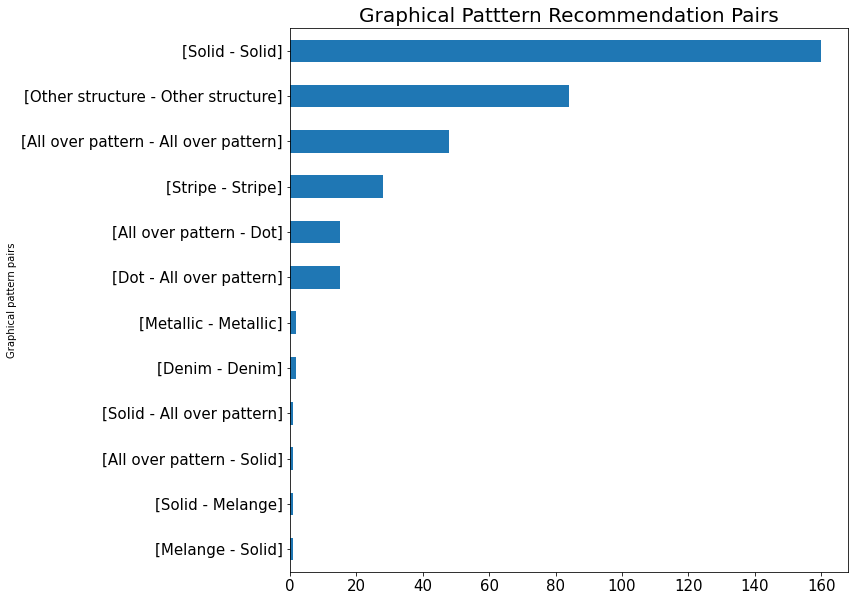

In [162]:
ax=rules.graphical.value_counts().sort_values().plot(kind = 'barh',xlabel = 'Graphical pattern pairs',\
                                                     ylabel = 'Count', title = 'Graphical Patttern Recommendation Pairs',\
                                                     fontsize = 15, figsize=(10,10))
ax.set_title('Graphical Patttern Recommendation Pairs', fontsize=20)

#### Perceived_colour_master_name

In [164]:
get_article_feature('perceived_colour_master_name','ante_master_color','consq_master_color')
rules['color'] = rules['ante_master_color'] + ' - '+rules['consq_master_color']
rules.color.value_counts()

TypeError: unhashable type: 'numpy.ndarray'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'numpy.ndarray'


[Green - Green]      82
[Blue - Blue]        56
[Red - Red]          48
[White - Black]      37
[Black - White]      37
[White - White]      24
[Black - Black]      22
[Orange - Orange]    16
[Yellow - Yellow]    14
[Pink - Pink]        12
[Beige - Beige]       4
[Brown - White]       1
[White - Brown]       1
[Black - Blue]        1
[Blue - Black]        1
[Grey - White]        1
[White - Grey]        1
Name: color, dtype: int64

### Build Insights into Recommendation System

In [57]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_info,consequents_info
0,(559616020),(739590024),0.0046,0.0044,0.0042,0.913043,207.509881,0.004180,11.449400,"[[559616020, Swimwear, Solid, Green, Ladieswea...","[[739590024, Swimwear, Solid, Green, Ladieswea..."
1,(739590024),(559616020),0.0044,0.0046,0.0042,0.954545,207.509881,0.004180,21.898800,"[[739590024, Swimwear, Solid, Green, Ladieswea...","[[559616020, Swimwear, Solid, Green, Ladieswea..."
2,(559630026),(599580055),0.0038,0.0076,0.0024,0.631579,83.102493,0.002371,2.693657,"[[559630026, Swimwear, All over pattern, Green...","[[599580055, Swimwear, Dot, Green, Ladieswear,..."
3,(599580055),(559630026),0.0076,0.0038,0.0024,0.315789,83.102493,0.002371,1.455985,"[[599580055, Swimwear, Dot, Green, Ladieswear,...","[[559630026, Swimwear, All over pattern, Green..."
4,(776237011),(599580038),0.0062,0.0082,0.0036,0.580645,70.810386,0.003549,2.365062,"[[776237011, Swimwear, Solid, Red, Ladieswear,...","[[599580038, Swimwear, Solid, Red, Ladieswear,..."
...,...,...,...,...,...,...,...,...,...,...,...
27,(860949001),(739590031),0.0030,0.0024,0.0020,0.666667,277.777778,0.001993,2.992800,"[[860949001, Swimwear, Stripe, Green, Ladieswe...","[[739590031, Swimwear, Stripe, Green, Ladieswe..."
28,(823165001),(823118001),0.0048,0.0032,0.0028,0.583333,182.291667,0.002785,2.392320,"[[823165001, Swimwear, Solid, Blue, Ladieswear...","[[823118001, Swimwear, Solid, Blue, Ladieswear..."
29,(823118001),(823165001),0.0032,0.0048,0.0028,0.875000,182.291667,0.002785,7.961600,"[[823118001, Swimwear, Solid, Blue, Ladieswear...","[[823165001, Swimwear, Solid, Blue, Ladieswear..."
30,(841383003),(841383002),0.0062,0.0072,0.0024,0.387097,53.763441,0.002355,1.619832,"[[841383003, Garment Upper body, Solid, White,...","[[841383002, Garment Upper body, Solid, Black,..."


In [58]:
ante = []
for i in antecedents.values:
    string = i[0]
    num = int(string)
    ante.append(num)
consq = []
for i in consequents.values:
    string = i[0]
    num = int(string)
    consq.append(num)

In [59]:
ante

[559616020,
 739590024,
 559630026,
 599580055,
 776237011,
 599580038,
 806225008,
 599580038,
 776237021,
 599580047,
 599580055,
 776237020,
 599580061,
 811835003,
 610776001,
 610776002,
 688537004,
 684209004,
 688537011,
 684209013,
 688537026,
 684209025,
 688537021,
 684209027,
 688537029,
 684209032,
 687034024,
 739590040,
 739590031,
 860949001,
 739590032,
 860949002,
 800691008,
 800691007,
 806388002,
 806388001,
 806388002,
 806388003,
 811925002,
 811927002,
 811925005,
 811927004,
 823165001,
 823118001,
 832331003,
 832330003,
 841699003,
 834217009,
 841383003,
 841383002,
 843873007,
 843872006,
 854619003,
 850176003,
 854683003,
 854677003,
 559616020,
 739590024,
 559630026,
 599580055,
 572797001,
 572797002,
 776237011,
 599580038,
 806225008,
 599580038,
 599580046,
 684209019,
 599580055,
 776237020,
 599580061,
 844294002,
 811835009,
 599580072,
 610776001,
 610776002,
 688537004,
 684209004,
 688537011,
 684209013,
 688537026,
 684209025,
 688537021,
 684

In [60]:
apyori_dict = dict(zip(ante, consq))
apyori_dict

{559616020: 739590024,
 739590024: 559616020,
 559630026: 599580055,
 599580055: 776237020,
 776237011: 599580038,
 599580038: 806225008,
 806225008: 599580038,
 776237021: 599580047,
 599580047: 776237021,
 776237020: 599580055,
 599580061: 844294002,
 811835003: 599580061,
 610776001: 610776002,
 610776002: 610776001,
 688537004: 684209004,
 684209004: 688537004,
 688537011: 684209013,
 684209013: 688537011,
 688537026: 684209025,
 684209025: 688537026,
 688537021: 684209027,
 684209027: 688537021,
 688537029: 684209032,
 684209032: 688537029,
 687034024: 739590040,
 739590040: 687034024,
 739590031: 860949001,
 860949001: 739590031,
 739590032: 860949002,
 860949002: 739590032,
 800691008: 800691007,
 800691007: 800691008,
 806388002: 806388009,
 806388001: 806388002,
 806388003: 806388002,
 811925002: 811927002,
 811927002: 811925002,
 811925005: 811927004,
 811927004: 811925005,
 823165001: 823118001,
 823118001: 823165001,
 832331003: 832330003,
 832330003: 832331003,
 841699003:

In [222]:
transactions

,t_dat,customer_id,article_id,price,sales_channel_id,month,day
0,2020-03-01,-7200416642310594310,751628002,0.022017,1,3,1
1,2020-03-01,8486166240428812738,675662028,0.035576,2,3,1
2,2020-03-01,-761612008142234995,821152004,0.025407,2,3,1
3,2020-03-01,-761612008142234995,860738001,0.025407,2,3,1
4,2020-03-01,-1779128939320411371,822957002,0.045746,2,3,1
...,...,...,...,...,...,...,...
6812501,2020-08-31,-8616969130790625436,658030020,0.050831,1,8,31
6812502,2020-08-31,-3663255835033856802,923643001,0.025407,2,8,31
6812503,2020-08-31,-3663255835033856802,894320001,0.033881,2,8,31
6812504,2020-08-31,9003752421700034502,873678002,0.025407,1,8,31


In [63]:
transactionss =  transactions[['customer_id','article_id']]
transactionss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6812506 entries, 0 to 6812505
Data columns (total 2 columns):
 #   Column       Dtype
---  ------       -----
 0   customer_id  int64
 1   article_id   int64
dtypes: int64(2)
memory usage: 104.0 MB


In [67]:
transactionss

,customer_id,article_id
0,-7200416642310594310,751628002
1,8486166240428812738,675662028
2,-761612008142234995,821152004
3,-761612008142234995,860738001
4,-1779128939320411371,822957002
...,...,...
6812501,-8616969130790625436,658030020
6812502,-3663255835033856802,923643001
6812503,-3663255835033856802,894320001
6812504,9003752421700034502,873678002


In [65]:
apyori_recomd = transactionss['article_id'].map(apyori_dict)

In [68]:
transactionss['apyori_recomd'] = apyori_recomd

In [70]:
transactionss['apyori_recomd'].isnull().sum()

6466171

In [71]:
transactionss['customer_id'] = transactionss['customer_id'].astype(str)

In [76]:
recom_grouped = transactionss.groupby('customer_id').agg({'apyori_recomd':lambda x:list(x)})

In [81]:
recom_grouped['apyori_recomd'] = recom_grouped['apyori_recomd'].apply(lambda x: [i for i in x if str(i) != "nan"])

In [82]:
recom_grouped

,apyori_recomd
customer_id,
-1000006309069194455,[]
-1000036844604231611,[]
-1000050196267142131,[]
-1000052543077660214,[]
-1000060282539483427,[783346001.0]
...,...
999902799079936447,[]
999919239910340283,[]
999938001182428423,[]
